<a href="https://colab.research.google.com/github/guiguilhermegui/TF/blob/main/modelo_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checkout www.pygimli.org for more examples
#!pip install pygimli tetgen


# Hydrogeophysical modelling

Coupled hydrogeophysical modelling example. This essentially represents the
forward modelling step of the example presented in section 3.2 of the [pyGIMLi
paper](http://www.sciencedirect.com/science/article/pii/S0098300417300584/pdfft?md5=44253eaacd5490e3fb32210671672496&pid=1-s2.0-S0098300417300584-main.pdf).


Create geometry definition for the modelling domain



In [2]:
#imports

import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro
from pygimli.physics import ERTManager

In [3]:
# Parametros dos furos
bores = [-20, -15, -10, -5, 0, 5, 10, 15]                       # Posição central dos furos
altura_poco=0
prof_poco=-0.9
raio_poco=0.35   #precisa ser decimal Ex:"3.00001"

# OK Posicoes relativas do furo
esq = '.' + f'{raio_poco:.2f}'.split('.')[1]
dir = '.' + f'{1 - raio_poco:.2f}'.split('.')[1]
#print(f'raio_poco={raio_poco:.2f} esq={esq} dir={dir}')

# limites world sandbox
box_esq=-30
box_dir=30
box_top=0.01
box_bottom=-20

# parâmetros de malha
mesh_area=0.4               # area da mesh em metros^2
mesh_quality=10             # qualidade da mesh evitar valores acima de 33 por questões de performance

# Atribute hydraulic conductivity in m/s to each region (interfaces/layers) of the model
K_poco = 1e4
K_mundo = 1e-9

#markers
kMap = [[1, K_mundo],  [9, K_poco]] #[0, 3e-1],    #Use [[RegionMarker, ConductivityValue], ...]

# Definições de variáveis e funções
#h0 = altura_poco            # Altura inicial da água no poço
#h2o = h0 - prof_poco        # Altura da linha da água inicial no poço
#h2o2=0
#y=0.0001
#y = 0.1  # Defina a variação na linha vertical da fronteira
# Defina os parâmetros iniciais hidráulicos
#taxa_de_infiltracao = 0.005 # Taxa de infiltração em m/s
#num_iteracoes = 20          # Número de iterações dt para simulação
#dt = 1                      # Intervalo de tempo em segundos

# Dirichlet conditions for hydraulic potential

# Definir valores de fronteira pro potencial hidráulico 
# fronteiras 1top, 2lat,3_fundo,4latmundo,-2basemundo,-1topomundo
base_2 = 0.0
topo7 = 0.9
#laterais8 = h202             # Defina a altura da água nas laterais
#fundo9 = 0.9   #h20           # Defina a altura da água no poço
pBound = {"Dirichlet": {-2: base_2, 1: topo7}} #{marker: value, ...} #Dirichlet, Neumann, Robin
#pBound = pBound.append("Neumann":{2: laterais8, 3:fundo9})


# Parâmetros do meio poroso para adveccao-dispersao
phi = 0.3                    # Porosidade meio
#D = 0.01                    # Coeficiente de dispersão m^2/s


# Fluid                      # Condutividade elétrica da água em S/m
# Create conductivity of fluid for salt concentration :math:`c` sigmaFluid = c[timesERT] * sigma_bx + sigma_a
sigma_a = -0.00031
sigma_bx = 0.19330           # Condutividade = A+bx   

TracerCon = 13.27            # Concentração em g/l

cementation_exponent = 1.1,  # Exponente de cimentação para a resistividade do solo



# Simulação
TimeSimu_days = 1            # Tempo de simulação em dias  
TimeSimu_slice = 2400        # Número de fatias para a simulação em time steps


# OK ERT parameters
ERT_dist= 600                # Distância total dos eletrodos em metros
ERT_elecs = 60               # Quantidade de eletrodos
ERT_spac = 10                # Espaçamento entre os eletrodos em metros
ERT_Array = 'dd'
elecs = np.linspace(-ERT_dist/2, ERT_dist/2, ERT_elecs)


In [4]:
# Create a 2D world box
world = mt.createWorld(start=[box_esq, box_top], end=[box_dir, box_bottom], WorldMarker=True,) #layers=[-2,-8]) 

# Create boreholes
poco = []
for pos in bores:
    poco.append(mt.createRectangle(start=[pos - raio_poco, altura_poco], end=[pos + raio_poco,prof_poco], marker=9))
boreholes = poco[0]
for borehole in poco[1:]:
    boreholes = boreholes + borehole


# Create geometry of model
geom = world + boreholes
mesh = mt.createMesh(geom, quality=mesh_quality, area=mesh_area, smooth=[1, 10])
#pg.show(mesh)

coord = []
# Create figure
#ax, _ = pg.show(geom, markers=False, orientation='vertical', figsize=(15, 8), showNodes=True, showMesh=True)
# Print nodes
for i, n in enumerate(geom.nodes()):
#    ax.text(n.x(), n.y(), str(i), color='blue', size=10)
    coord.append([i, n.x(), n.y()])
# Print 4 lists of nodes per line, very useful for rectangles
#for i in range(0, len(coord), 4):
#    print('coord' + str(coord[i:i+4]))


In [5]:
# Calculo doido de coordenadas dos nós
leftneg_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] < 0 and str(boundary.center()[0]).endswith(esq))]
leftpos_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] > 0 and str(boundary.center()[0]).endswith(dir))]
rightpos_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] > 0 and str(boundary.center()[0]).endswith(esq))]
rightneg_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] < 0 and str(boundary.center()[0]).endswith(dir))]
left_boundaries = leftneg_boundaries + leftpos_boundaries
right_boundaries = rightneg_boundaries + rightpos_boundaries

top_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] == altura_poco]
bottom_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] ==prof_poco]
world_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.id() not in top_boundaries + bottom_boundaries + left_boundaries + right_boundaries]

#print('left_boundaries: ' + str(left_boundaries))
#print('bottom_boundaries: ' + str(bottom_boundaries))
#print('right_boundaries: ' + str(right_boundaries))
#print('top_boundaries: ' + str(top_boundaries))
#print('world_boundaries: ' + str(world_boundaries))


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

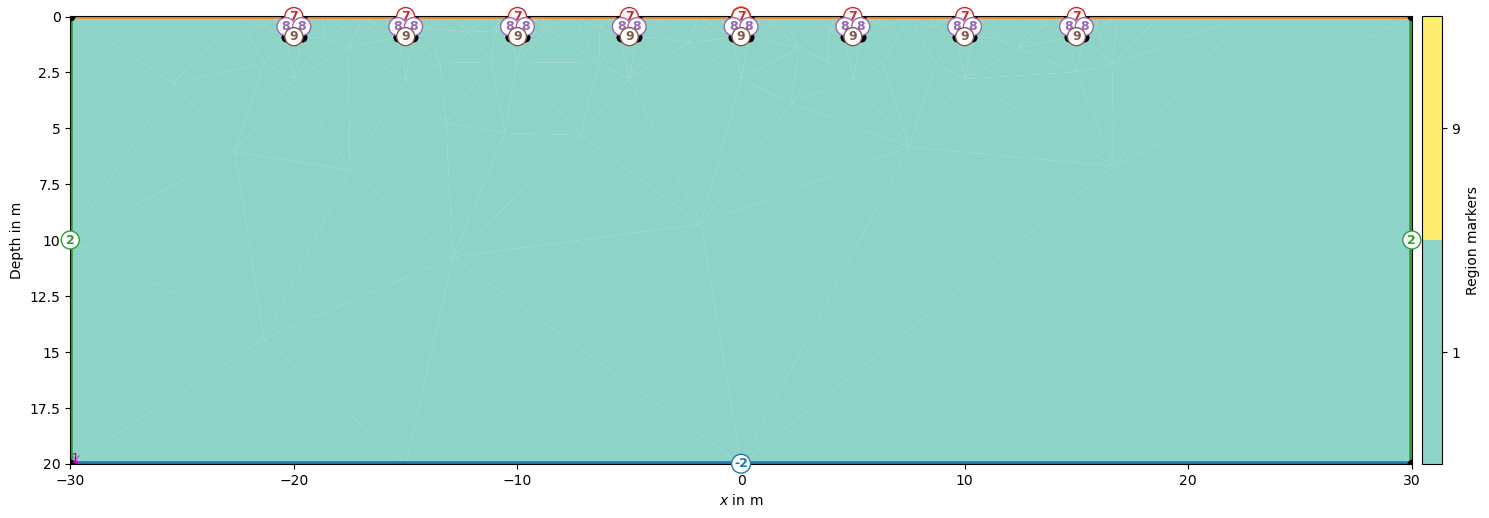

In [6]:
# Atribuição da numeracao das fronteiras boreholes
def pos(count):
    return pg.Pos(coord[count][1], coord[count][2])
for a in range(len(bottom_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(right_boundaries[a]), marker=9)

for a in range(len(right_boundaries)):
    geom.createEdge(geom.node(top_boundaries[a]), geom.node(right_boundaries[a]), marker=8)

for a in range(len(left_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(left_boundaries[a]), marker=8)
for a in range(len(top_boundaries)):
    geom.createEdge(geom.node(left_boundaries[a]), geom.node(top_boundaries[a]), marker=7)


# Fronteiras world
geom.createEdge(geom.node(0), geom.node(1), marker= 2)#esq
geom.createEdge(geom.node(1), geom.node(2), marker=-2)#fundo
geom.createEdge(geom.node(2), geom.node(3), marker= 2)#dir
geom.createEdge(geom.node(3), geom.node(0), marker= -1)#topo mundo

pg.show(geom, label='Boundary marker', markers=True, showMesh=True, figsize=(15, 8), orientation='vertical' )

Fluid flow in a porous medium of slow non-viscous and non-frictional hydraulic
movement is governed by Darcy's Law according to:

\begin{align}K^{-1}\mathbf{v} + \nabla p & = 0 \\
   \nabla \cdot \mathbf{v} & = 0\\
   \text{leading}\,\,\text{to}\,\,
   \nabla\cdot(K \nabla p) & = 0 \quad \text{on} \quad\Omega\end{align}

We begin by defining isotropic values of hydraulic conductivity $K$ and
mapping these to each mesh cell:



In [7]:

# Map conductivity value per region to each cell in the given mesh
K = pg.solver.parseMapToCellArray(kMap, mesh)

#pg.show(mesh, data=K, label='Hydraulic conductivity $K$ in m/s', cMin=1e-10, cMax=1e12, logScale=True, grid=True)

The problem further boundary conditions of the hydraulic potential. We use
$p=p_0=0.75$ m on the left and $p=0$ on the right boundary of the modelling
domain, equaling a hydraulic gradient of 1.75%.



In [8]:
#parcial = 10
#mostrar_parcial = False
#mostrar_cada_iteracao = False

#p = np.random.rand(mesh.cellCount())                   # Inicialize com potencial hidráulico aleatorio


# Resolver o modelo de potencial hidráulico
p = pg.solver.solveFiniteElements(mesh, a=K, bc=pBound, verbose=True)


#Loop para simular o preenchimento e esvaziamento do poço 
# 
# 
# ## já vai ser feito lá embaixo em FiniteVolume  
#   ainda vai precisar simular esvaziamento pras fronteiras laterais do poço
# 
# Calcular a nova altura do poço com base na taxa de esvaziamento
#h2o = h0 - prof_poco - taxa_de_infiltracao * dt
# Garantir que a altura do poço não fique negativa


#    if mostrar_cada_iteracao == True:
#        pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))
#    if mostrar_parcial == True:
#        if t % parcial == 0:
#            pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))




# (Opcional) Adicionar uma pausa para visualização
# plt.pause(0.1)  # Se você estiver usando matplotlib para visualização
#pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))
#print(pBound)
#print(h2o)




Mesh:  Mesh: Nodes: 2723 Cells: 5168 Boundaries: 7890
Assembling time:  0.022486
Solving time:  0.0369255


We can now call the finite element solver with the generated mesh, hydraulic
conductivity and the boundary condition. The sought hydraulic velocity
distribution can then be calculated as the gradient field of
$\mathbf{v}=-\nabla p$ and visualized using the generic `pg.show()` function.



In [9]:
# Calculate statistics
mean_p = np.mean(p)
std_p = np.std(p)
min_p = np.min(p)
max_p = np.max(p)

print(f"Mean: {mean_p}, Std: {std_p}, Min: {min_p}, Max: {max_p}")

Mean: 0.37261594062435566, Std: 0.30381096688642195, Min: 0.0, Max: 0.9008507031376001


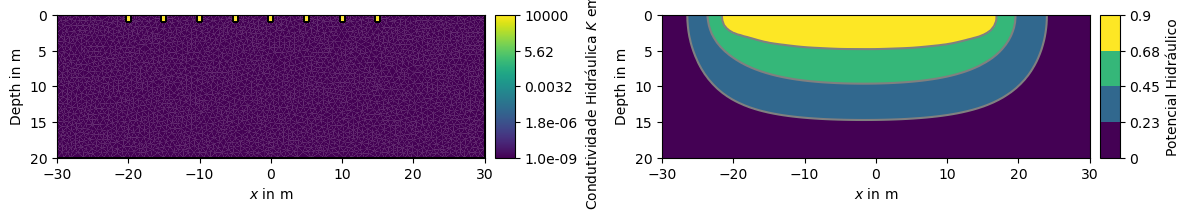

In [10]:
# Atualizar a visualização ou armazenar resultados
fig, axs = plt.subplots(1,2,figsize=(12, 12))
pg.show(mesh, data=K, label='Condutividade Hidráulica $K$ em m/s', logScale=True, ax=axs[0],orientation='vertical')
pg.show(mesh, data=p, label='Potencial Hidráulico', cMin=min_p, cMax=max_p, ax=axs[1],orientation='vertical')
plt.show()

Mean Velocity: -9.861288577766719e-12, Std: 2.4197370589286368e-11, Min: -2.4395228934960834e-10, Max: 1.8699966155129102e-10


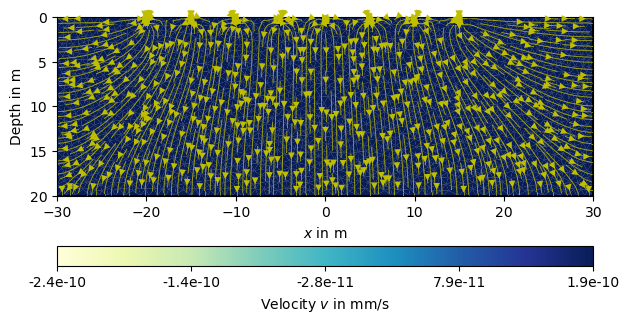

In [11]:
# Solve velocity as gradient of hydraulic potential
vel = -pg.solver.grad(mesh, p) * np.asarray([K, K, K]).T #4d

# Calculate statistics for the new range
mean_vel = np.mean(vel)
std_vel = np.std(vel)
min_vel = np.min(vel)
max_vel = np.max(vel)

print(f"Mean Velocity: {mean_vel}, Std: {std_vel}, Min: {min_vel}, Max: {max_vel}")

ax, _ = pg.show(mesh, data=pg.abs(vel) * 1000, cMin=min_vel, cMax=max_vel,
                label='Velocity $v$ in mm/s', cMap='YlGnBu', hold=True)
ax, _ = pg.show(mesh, data=vel, ax=ax, color='y', linewidth=0.6, dropTol=1e-12,
                hold=True)

In [12]:
# Initialize the source vector of injections
load_vector = pg.Vector(mesh.cellCount(), 0.0)

# Fill injection source vector for a fixed injection position
for pos in bores:
    sourceCell = mesh.findCell(pos,0)
    if sourceCell:
        load_vector[sourceCell.id()] += TracerCon / sourceCell.size()  # g/(l s)




In [13]:
# Choose n slices  time steps for TimeSimulation days to seconds
t = pg.utils.grange(0, TimeSimu_days * 24 * 3600, n=TimeSimu_slice)

# Create dispersitivity, depending on the absolute velocity
dispersion = pg.abs(vel) * 1e2  # thik it is to transform from mm/s to m/s ?

# Solve for injection time, but we need velocities on cell nodes
veln = mt.cellDataToNodeData(mesh, vel)
c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=load_vector, vel=veln, times=t,
                                 scheme='PS', verbose=0)

# Solve without injection starting with last result
c2 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=0, vel=veln, u0=c1[-1],
                                 times=t, scheme='PS', verbose=0)
# Stack results together
c = np.vstack((c1, c2))

# We can now visualize the result:
# Calculate statistics
mean_c = np.mean(c)
std_c = np.std(c)
min_c = np.min(c)
max_c = np.max(c)

print(f"Mean: {mean_c}, Std: {std_c}, Min: {min_c}, Max: {max_c}")



c:\Users\gui\.conda\envs\pg\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Mean: 5324237.2504831, Std: 416645854.03420454, Min: 0.0, Max: 36687066006.69604


c:\Users\gui\.conda\envs\pg\lib\site-packages\pygimli\viewer\showmesh.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax = pg.plt.subplots(figsize=kwargs.pop('figsize', None))[1]


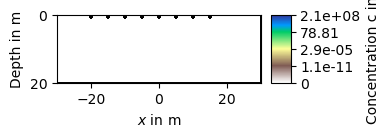

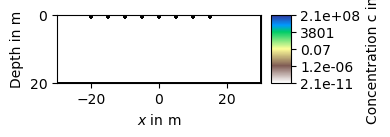

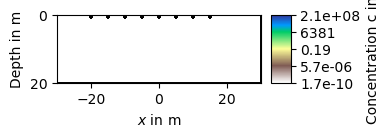

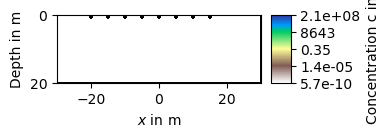

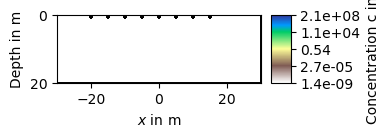

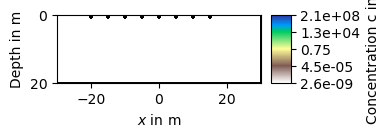

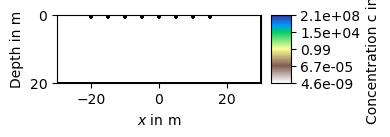

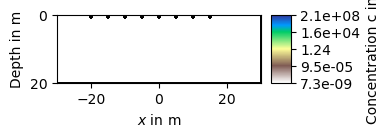

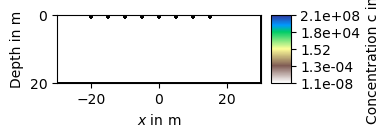

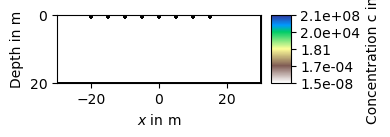

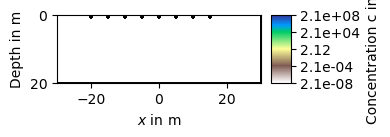

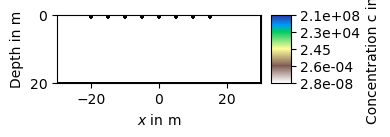

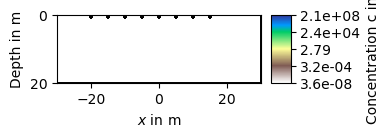

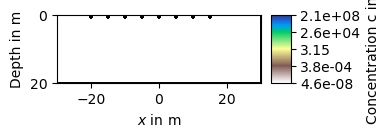

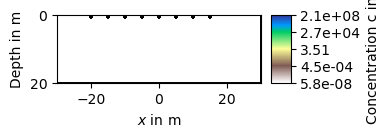

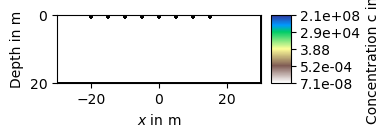

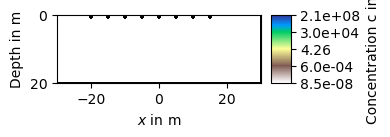

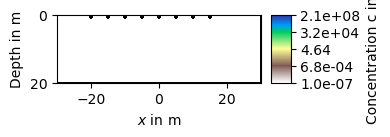

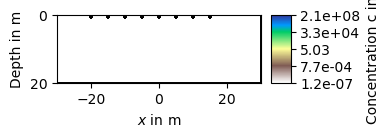

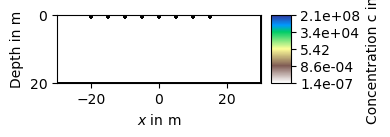

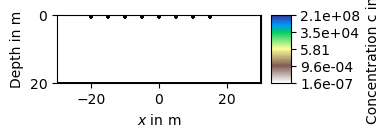

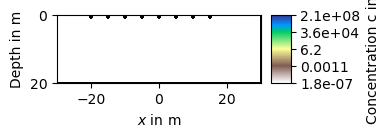

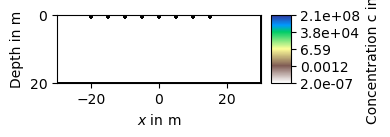

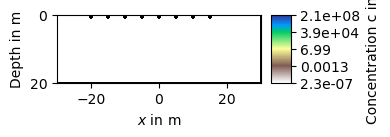

In [14]:
min_c_calc=mean_c-1*std_c
max_c_calc=mean_c+1*std_c

# Visualize the result
for ci in c[1:][::200]:
    pg.show(mesh, data=ci * 0.001, cMin=min_c_calc, cMax=max_c_calc, cMap="terrain_r", logScale=True,
            label="Concentration c in g/l",figsize=(4, 8), orientation='vertical')
    

Warning! DataSchemeBase::create has unhandled arguments
{'spacing': 10}


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

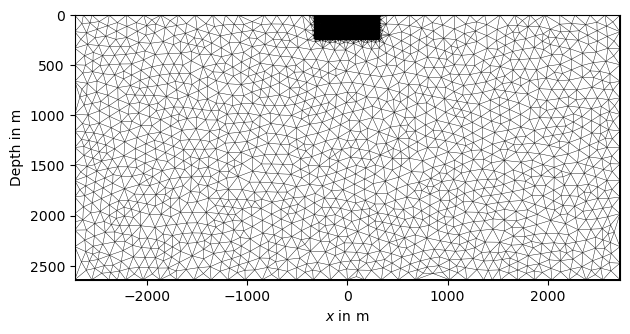

In [15]:
# Create ERT measurement scheme

ertScheme = ert.createData(elecs=elecs, schemeName=ERT_Array, spacing=ERT_spac)

meshERT = mt.createParaMesh(ertScheme, quality=mesh_quality, paraMaxCellSize=10, nLayers=1,
boundaryMaxCellSize=7500, smooth=[1, 2])

pg.show(meshERT)

In [16]:

timesERT = pg.IVector(np.floor(np.linspace(0, len(c) - 1, 10)).astype(int)) # Select 10 time frame to simulate ERT data

# Create conductivity of fluid for salt concentration :math:`c`
sigmaFluid = c[timesERT] * sigma_bx + sigma_a

c = np.array(c)  # Ensure c is a numpy array

# Calculate bulk resistivity based on Archie's Law
resBulk = petro.resistivityArchie(rFluid=1. / sigmaFluid, porosity=phi, m=cementation_exponent,
                                  mesh=mesh, meshI=meshERT, fill=1)

# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount()) + 1000.
for cell in meshERT.cells():
    if cell.center()[1] < -8:
        rho0[cell.id()] = 150.
    elif cell.center()[1] < -2:
        rho0[cell.id()] = 500.
resis = pg.Matrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1. / rbI) + 1. / rho0)



09/01/25 - 14:03:52 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 1.3 within mesh.


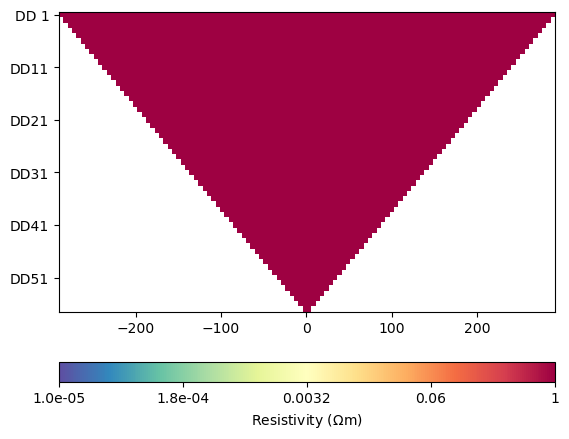

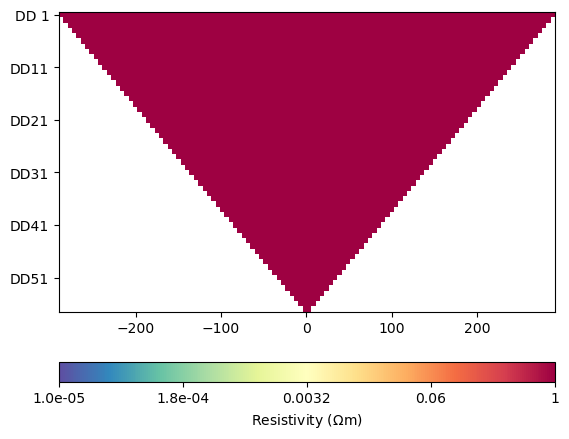

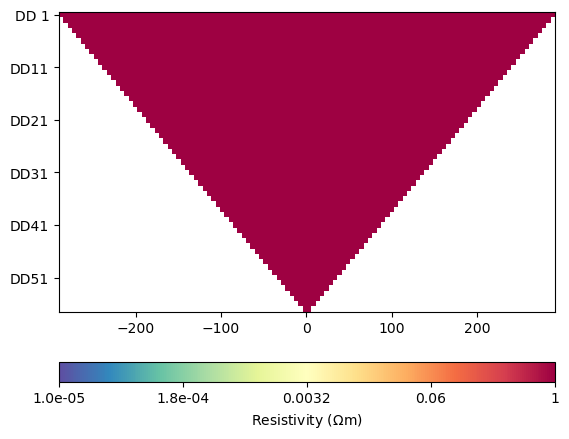

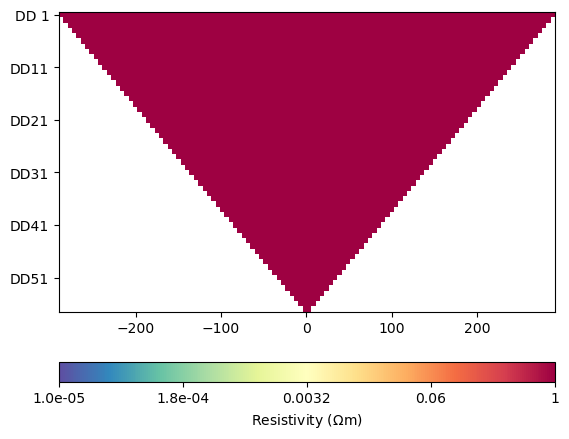

In [17]:
ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme, 
                    returnArray=True, verbose=False)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0], cMin=1e-5, cMax=1)

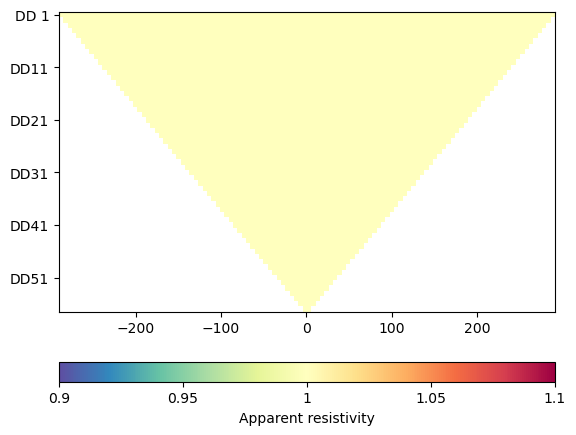

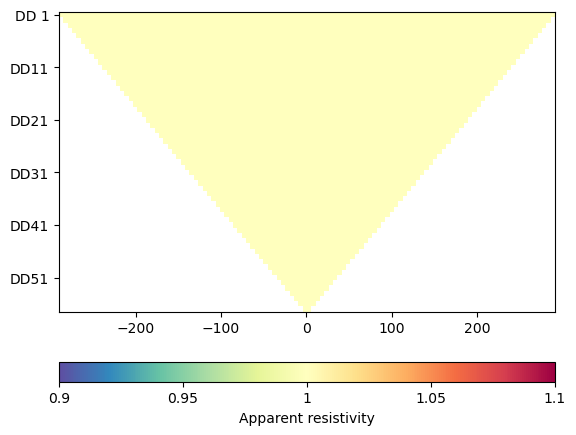

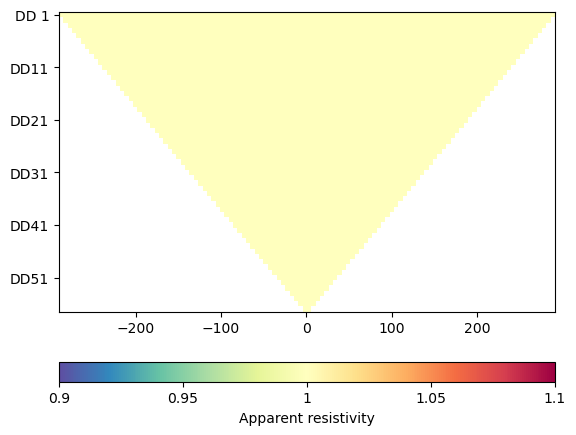

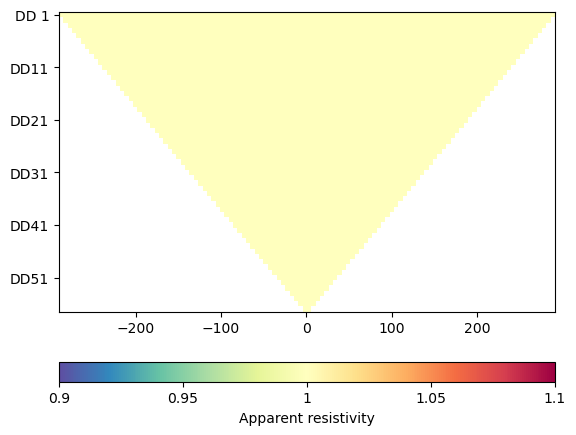

In [18]:
ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme,
                    returnArray=True, verbose=False)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0], logScale=False, label='Apparent resistivity',)